In [1]:
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [32]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 280)

football_feed_df = pd.read_csv('football_feed_df_final.csv')
print(football_feed_df.columns)
football_feed_df.head()

Index(['Unnamed: 0', 'created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'metadata',
       'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status', 'retweet_count',
       'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive',
       'lang', 'team', 'user_id', 'retweeted_status_id', 'hashtags',
       'user_mentions', 'emoji', 'processed_text', 'Unnamed: 0.1', 'text'],
      dtype='object')


,Unnamed: 0,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,geo,coordinates,place,contributors,is_quote_status,quoted_status_id,quoted_status_id_str,quoted_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,team,user_id,retweeted_status_id,hashtags,user_mentions,emoji,processed_text,Unnamed: 0.1,text
0,0,Thu Nov 19 15:16:52 +0000 2020,1329443531694481411,1329443531694481411,"Thinking about how many Iowa meat packers voted for Bernie who would’ve given them ownership stake in their business, greater control over their conditions, and Medicare for All.",False,"[0, 202]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/wef0Do6kyu', 'expanded_url': 'https://twitter.com/dmregister/status/1329431739475832835', 'display_url': 'twitter.com/dmregister/sta…', 'indices': [179, 202]}], 'media': [{'id': 13294435273114...","{'media': [{'id': 1329443527311450121, 'id_str': '1329443527311450121', 'indices': [203, 226], 'media_url': 'http://pbs.twimg.com/media/EnMh2CpXYAkQrUs.jpg', 'media_url_https': 'https://pbs.twimg.com/media/EnMh2CpXYAkQrUs.jpg', 'url': 'https://t.co/xlo5NGg6iD', 'display_url':...","{'result_type': 'popular', 'iso_language_code': 'en'}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.329432e+18,1.329432e+18,"{'created_at': 'Thu Nov 19 14:30:00 +0000 2020', 'id': 1329431739475832835, 'id_str': '1329431739475832835', 'full_text': ""A lawsuit claims that the manager at Tyson's Waterloo plant a betting pool for supervisors and managers to wager how many plant employees would test posi...",329,2744,False,False,False,en,Packers,1332630685,NaN,[],NaN,[],"Thinking many Iowa meat packer voted Bernie would ’ given ownership stake business , greater control condition , Medicare All .",NaN,NaN
1,1,Thu Nov 19 21:19:15 +0000 2020,1329534730115702787,1329534730115702787,Packers' WR Davante Adams did not practice today due to an ankle injury.,False,"[0, 72]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}",NaN,"{'result_type': 'popular', 'iso_language_code': 'en'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,186,3856,False,False,NaN,en,Packers,51263592,NaN,[],NaN,[],Packers ' WR Davante Adams practice today due ankle injury .,NaN,NaN
2,2,Fri Nov 20 20:19:18 +0000 2020,1329882030855892998,1329882030855892998,"#Packers WR Davante Adams is officially off the injury report and will play Sunday against the #Colts, while WR Allen Lazard (core) is listed as questionable.",False,"[0, 158]","{'hashtags': [{'text': 'Packers', 'indices': [0, 8]}, {'text': 'Colts', 'indices': [95, 101]}], 'symbols': [], 'user_mentions': [], 'urls': []}",NaN,"{'result_type': 'popular', 'iso_language_code': 'en'}","<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,74,727,False,False,NaN,en,Packers,36089053,NaN,"[{'text': 'Packers', 'indices': [0, 8]}, {'text': 'Colts', 'indices': [95, 101]}]",NaN,[],"# Packers WR Davante Adams officially injury report play Sunday # Colts , WR Allen Lazard ( core ) listed questionable .",NaN,NaN
3,3,Sat Nov 21 08:07:18 +0000 2020,1330060203845410817,1330060203845410817,"Highlights are the #ALR &amp; BC Food Security, including the KPU Farm School on the Garden City Lands. Then #RichmondBC Garry Point &amp; Terra Nova Parks, Trails, Gulf of Georgia Cannery &amp; Britannia Shipyard. On the down side loss of BC Packers Cannery for a seafood mar...",False,"[14, 310]","{'hashtags': [{'text': 'ALR', 'indices': [33, 37]}, {'text': 'RichmondBC', 'indices': [123, 134]}, {'text': 'SiteC', 'indices': [300, 306]}], 'symbols': [], 'user_men

In [8]:
#check to see how many repeat tweets we scraped. 

print(len(football_feed_df.full_text))
print(len(set(football_feed_df.full_text)))

4500
4499


In [9]:
#drop duplicate tweets 
football_feed_df.drop_duplicates(subset=['full_text'], inplace=True)
football_feed_df['team']= football_feed_df['team'].str.replace('DaBears', 'Bears')
football_feed_df['team'] = football_feed_df['team'].str.replace('ChiefsKingdom', 'Chiefs')

In [10]:
#check to make sure the number of tweets per team remains similar 
football_feed_df['team'].value_counts()

Cowboys    866
Chiefs     842
Eagles     733
Packers    728
Raiders    725
Bears      605
Name: team, dtype: int64

In [11]:
#shuffle the data 
np.random.seed(1)
df = football_feed_df.reindex(np.random.permutation(football_feed_df.index))

In [12]:
import re
contraction_patterns=[(r'can\'t', 'cannot'),
                    (r'haven\'t', 'have not'),
                    (r'(\w+)\'ll', '\g<1> will'),
                    (r'(\w+)\'re', '\g<1> are'),
                     (r'(\w+)\'ve', '\g<1> have'), 
                     (r'don\'t', 'do not')]

class contraction_replacer(object):
    def __init__(self, contraction_patterns):        
        # store compiled regex object
        self._contraction_regexes = [(re.compile(p), replaced_text) for p, replaced_text in contraction_patterns]
        
    def do_contraction_normalization(self, text):
        for contraction_regex, replaced_text in self._contraction_regexes:
            text = contraction_regex.sub(replaced_text, text)
        return text     
contraction_replacer = contraction_replacer(contraction_patterns)

In [13]:
def clean_tweet(tweet):
    btweet = contraction_replacer.do_contraction_normalization(tweet)
    wnetl = WordNetLemmatizer()
    ctweet = wnetl.lemmatize(btweet)
    word_regex= nltk.RegexpTokenizer(pattern=r'\w+', gaps=False)
    clean_tweet = word_regex.tokenize(ctweet)
    stopwords = nltk.corpus.stopwords.words('english')
    stop_clean_sent = [w for w in clean_tweet if w not in stopwords]
    return stop_clean_sent

In [14]:
football_feed_df["full_text"] = football_feed_df["full_text"].apply(str)
clean_football_tweets = football_feed_df["full_text"].apply(clean_tweet)
football_feed_df['tokens'] = football_feed_df["full_text"].apply(clean_tweet)

clean_football_tweets[0:3]

0    [Thinking, many, Iowa, meat, packers, voted, Bernie, would, given, ownership, stake, business, greater, control, conditions, Medicare, All]
1                                                                             [Packers, WR, Davante, Adams, practice, today, due, ankle, injury]
2                  [Packers, WR, Davante, Adams, officially, injury, report, play, Sunday, Colts, WR, Allen, Lazard, core, listed, questionable]
Name: full_text, dtype: object

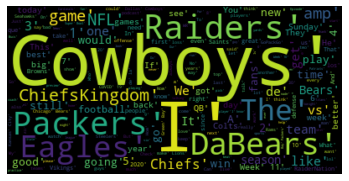

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

unique_string=(" ").join(map(str, clean_football_tweets))
wordcloud = WordCloud().generate(unique_string)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


plt.show()

Packers


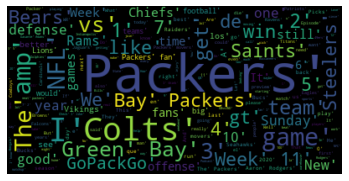

Bears


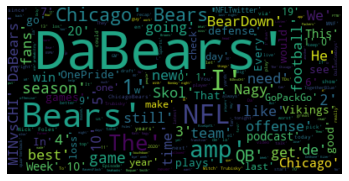

Eagles


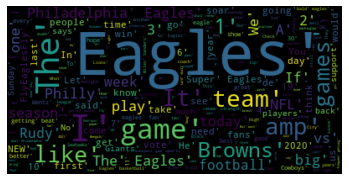

Cowboys


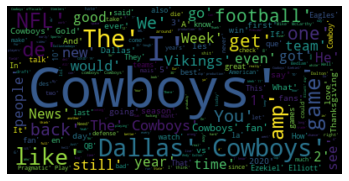

Raiders


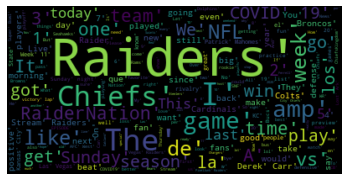

Chiefs


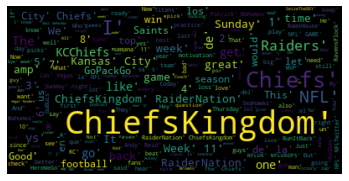

In [16]:
teams = ["Packers","Bears","Eagles", "Cowboys","Raiders", "Chiefs"]

for i in range(len(teams)):
    df = football_feed_df[football_feed_df['team']==teams[i]]
    print(teams[i])
    unique_string=(" ").join(map(str, df.tokens))
    wordcloud = WordCloud().generate(unique_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")


    plt.show()

# Naive Bayes Classifier

In [18]:
from nltk.corpus import twitter_samples

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens) 
        
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

In [19]:
clean_positive = pd.Series(positive_tweets).apply(clean_tweet)
clean_negative = pd.Series(negative_tweets).apply(clean_tweet)

clean_positive = get_tweets_for_model(clean_positive)
clean_negative = get_tweets_for_model(clean_negative)


In [20]:
positive_dataset = [(tweet_dict, 1)
                     for tweet_dict in clean_positive]

negative_dataset = [(tweet_dict, 0)
                     for tweet_dict in clean_negative]

dataset = positive_dataset + negative_dataset
random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]


In [21]:

from nltk import classify
from nltk import NaiveBayesClassifier
classifier = nltk.NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

#print(classifier.show_most_informative_features(10))


Accuracy is: 0.769


In [22]:
football_clean = get_tweets_for_model(clean_football_tweets)

football_dat = [(tweet_dict)
                     for tweet_dict in football_clean]

In [23]:
classifier.classify(football_dat[0])

#Classify each tweet one by one (not a vectorized process)
sentiment = []
for tweet in football_dat:
    s = classifier.classify(tweet)
    sentiment.append(s)

football_feed_df['sentiment'] = sentiment

In [24]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

football_feed_df[['full_text', 'sentiment']]



,full_text,sentiment
0,"Thinking about how many Iowa meat packers voted for Bernie who would’ve given them ownership stake in their business, greater control over their conditions, and Medicare for All.",1
1,Packers' WR Davante Adams did not practice today due to an ankle injury.,0
2,"#Packers WR Davante Adams is officially off the injury report and will play Sunday against the #Colts, while WR Allen Lazard (core) is listed as questionable.",1
3,"Highlights are the #ALR &amp; BC Food Security, including the KPU Farm School on the Garden City Lands. Then #RichmondBC Garry Point &amp; Terra Nova Parks, Trails, Gulf of Georgia Cannery &amp; Britannia Shipyard. On the down side loss of BC Packers Cannery for a seafood market &amp; #SiteC Dam",1
4,"The Packers have Rodgers \n\nThe Brewers have Yelich\n\nThe Bucks have Giannis \n\nI am a Wisconsin sports fan asking, once agai…",1
...,...,...
4495,I'm almost more concerned about the Dolphins game this season than the Saints.,0
4496,Early days I know but if Miami drafts well (&amp; they’ve got ALOT of picks coming up) they could be a problem in the A…,0
4497,Chase Young. Didn’t hear his name all game.....until his late hit.,1
4498,Chase Young...... why?!,0


## read in journalism scrape

In [25]:
football_articles = pd.read_csv('sports_journalism.csv') #row 15 has text NAN
football_articles.isna().sum()

football_articles.dropna(subset=['Text'], inplace=True)
football_articles.isna().sum()#make sure there are no nans in txt or team 

football_articles['Team'].value_counts() #make sure team counts roughly even 

chiefs     117
bears      105
packers    100
eagles      95
cowboys     87
raiders     59
Name: Team, dtype: int64

In [26]:
#preprocess article text
article_tokens = football_articles["Text"].apply(clean_tweet)
clean_article = get_tweets_for_model(article_tokens)

article_dat = [(art_dict)
                     for art_dict in clean_article]
#article_dat[0:3]

In [27]:
sentiment = []
for a in article_dat:
    s = classifier.classify(a)
    sentiment.append(s)

football_articles['sentiment'] = sentiment

In [28]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 50)

football_articles[['Text', 'sentiment']]

,Text,sentiment
0,Chiefs coach Andy Reid addresses the Raiders' ...,1
1,Patrick Mahomes is announced as a member of th...,1
2,Chicago native Michael Wilbon says Theo Epstei...,1
3,"GREEN BAY, Wis. -- It's not Marquez Valdes-Sca...",0
4,"FRISCO, Texas -- As the country experiences a ...",0
...,...,...
559,Just as we thought the Kansas City Chiefs were...,1
560,Tucker D. FranklinWhile there are many Kansas ...,1
561,Chiefs Chairman and CEO Clark Hunt's decision ...,1
562,TNS. FNLWatch!! Eifel Grand Prix Live Online: ...,1


In [29]:
##combine the sources 
football_feed_df['source'] = ['Twitter' for r in range(len(football_feed_df))]
football_articles['source'] = ['Web Article' for r in range(len(football_articles))]

football_articles.rename(columns={'Team': 'team', 'Text': 'full_text'}, inplace=True)
football_articles['team'] = football_articles['team'].str.capitalize()
total_df = pd.concat([football_feed_df[['full_text', 'team', 'source', 'sentiment']], football_articles[['full_text', 'team', 'source', 'sentiment']]])

print(total_df['team'].value_counts())

total_df

Chiefs     959
Cowboys    953
Eagles     828
Packers    828
Raiders    784
Bears      710
Name: team, dtype: int64


,full_text,team,source,sentiment
0,Thinking about how many Iowa meat packers vote...,Packers,Twitter,1
1,Packers' WR Davante Adams did not practice tod...,Packers,Twitter,0
2,#Packers WR Davante Adams is officially off th...,Packers,Twitter,1
3,Highlights are the #ALR &amp; BC Food Security...,Packers,Twitter,1
4,The Packers have Rodgers \n\nThe Brewers have...,Packers,Twitter,1
...,...,...,...,...
559,Just as we thought the Kansas City Chiefs were...,Chiefs,Web Article,1
560,Tucker D. FranklinWhile there are many Kansas ...,Chiefs,Web Article,1
561,Chiefs Chairman and CEO Clark Hunt's decision ...,Chiefs,Web Article,1
562,TNS. FNLWatch!! Eifel Grand Prix Live Online: ...,Chiefs,Web Article,1


team
Bears      0.583099
Chiefs     0.576642
Cowboys    0.495278
Eagles     0.554348
Packers    0.542271
Raiders    0.561224
Name: sentiment, dtype: float64

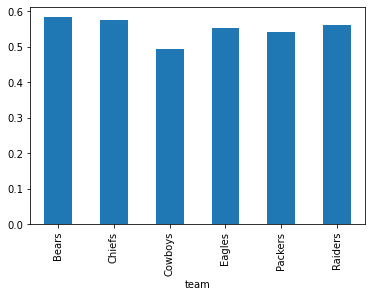

In [30]:
#group by teams
total_df.groupby('team')['sentiment'].mean().plot.bar()
total_df.groupby('team')['sentiment'].mean()

In [31]:
total_df.groupby(['team', 'source'])['sentiment'].mean()

team     source     
Bears    Twitter        0.555372
         Web Article    0.742857
Chiefs   Twitter        0.539192
         Web Article    0.846154
Cowboys  Twitter        0.475751
         Web Article    0.689655
Eagles   Twitter        0.540246
         Web Article    0.663158
Packers  Twitter        0.516484
         Web Article    0.730000
Raiders  Twitter        0.558621
         Web Article    0.593220
Name: sentiment, dtype: float64